In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0, '../scripts')
from utils import *

In [123]:
import gensim
from gensim.models import word2vec, Word2Vec

In [124]:
plt.rcParams['figure.figsize'] = (12, 10)

In [125]:
from sklearn.linear_model import LogisticRegression

In [186]:
def get_vecs(q1, q2):
    vecs_q1 = []
    vecs_q2 = []

    for i, j in zip(q1, q2):
        vecs_q1.append(sum(model.word_vec(x) if x in model.vocab else np.zeros(300) for x in i))
        vecs_q2.append(sum(model.word_vec(x) if x in model.vocab else np.zeros(300) for x in j))
        
    return np.array(vecs_q1), np.array(vecs_q2)

def get_average_embeddings_w2v(q1, q2):
    vecs_q1, vecs_q2 = get_vecs(q1, q2)
    w2v_dist = (vecs_q1 - vecs_q2)**2
    w2v_avg_dist = np.mean(w2v_dist, axis=1)
    return w2v_avg_dist

In [139]:
train_data = pd.read_csv('../data/clean-train.csv').dropna(axis=0)
test_data = pd.read_csv('../data/clean-test.csv').dropna(axis=0)

In [140]:
q1_list = train_data['q1'].str.split(' ').values.tolist()
q2_list = train_data['q2'].str.split(' ').values.tolist()

In [141]:
q1_list_test = test_data['q1'].str.split(' ').values.tolist()
q2_list_test = test_data['q2'].str.split(' ').values.tolist()

## Word2Vec Embeddings

In [188]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

In [189]:
vecs_q1, vecs_q2 = get_vecs(q1_list, q2_list)
vecs_q1_test, vecs_q2_test = get_vecs(q1_list_test, q2_list_test)

In [143]:
w2v_avg_dist = get_average_embeddings_w2v(q1_list, q2_list)
w2v_avg_dist_test = get_average_embeddings_w2v(q1_list_test, q2_list_test)

In [144]:
w2v_train_df = pd.DataFrame(data={'avg_dist': w2v_avg_dist, 'is_same': train_data['is_same']})

/Users/maded/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
  


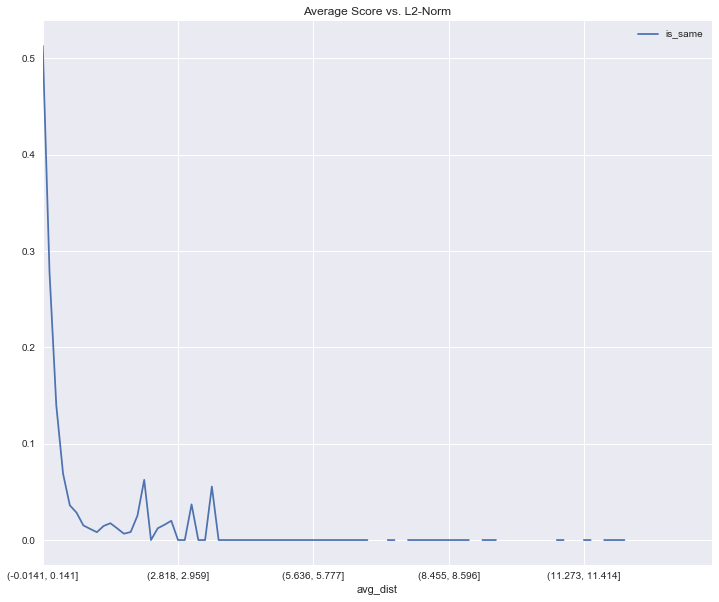

In [145]:
ax = pd.groupby(w2v_train_df, pd.cut(w2v_train_df['avg_dist'],
                                100))[['is_same']].mean().plot(title='Average Score vs. L2-Norm')
plt.savefig('../images/l2w2v.png')

In [146]:
log_w2v = LogisticRegression(class_weight='balanced')
log_w2v.fit(w2v_df['avg_dist'][:, np.newaxis], w2v_df['is_same'][:, np.newaxis]);

/Users/maded/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [147]:
generate_report(test_data['is_same'], log_w2v.predict(w2v_avg_dist_test[:, np.newaxis]),
                    log_w2v.predict_proba(w2v_avg_dist_test[:, np.newaxis])[:, 1])

Loss Report
-----------

Accuracy Score: 0.6206
ROC  AUC Score: 0.7255
Log Loss Score: 0.6190


(0.62058772602468648, 0.7255169754496883, 0.6190482720563677)

## GloVe Embeddings

In [137]:
from gensim.scripts import glove2word2vec

In [111]:
glove_model = gensim.models.KeyedVectors.load_word2vec_format('../data/glove.w2v.txt')

In [148]:
glove_vecs_q1 = []
glove_vecs_q2 = []

for i, j in zip(q1_list, q2_list):
    glove_vecs_q1.append(sum(glove_model.word_vec(x) if x in glove_model.vocab else np.zeros(300) for x in i))
    glove_vecs_q2.append(sum(glove_model.word_vec(x) if x in glove_model.vocab else np.zeros(300) for x in j))

glove_vecs_q1, glove_vecs_q2 = np.array(glove_vecs_q1), np.array(glove_vecs_q2)
glove_dist = (glove_vecs_q1 - glove_vecs_q2)**2
glove_avg_dist = np.mean(glove_dist, axis=1)

In [149]:
glove_vecs_q1_test = []
glove_vecs_q2_test = []

for i, j in zip(q1_list_test, q2_list_test):
    glove_vecs_q1_test.append(sum(glove_model.word_vec(x) if x in glove_model.vocab else np.zeros(300) for x in i))
    glove_vecs_q2_test.append(sum(glove_model.word_vec(x) if x in glove_model.vocab else np.zeros(300) for x in j))

glove_vecs_q1_test, glove_vecs_q2_test = np.array(glove_vecs_q1_test), np.array(glove_vecs_q2_test)
glove_dist_test = (glove_vecs_q1_test - glove_vecs_q2_test)**2
glove_avg_dist_test = np.mean(glove_dist_test, axis=1)

In [150]:
glove_train_df = pd.DataFrame(data={'glove_avg_dist': glove_avg_dist, 'is_same': train_data['is_same']})

/Users/maded/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
  


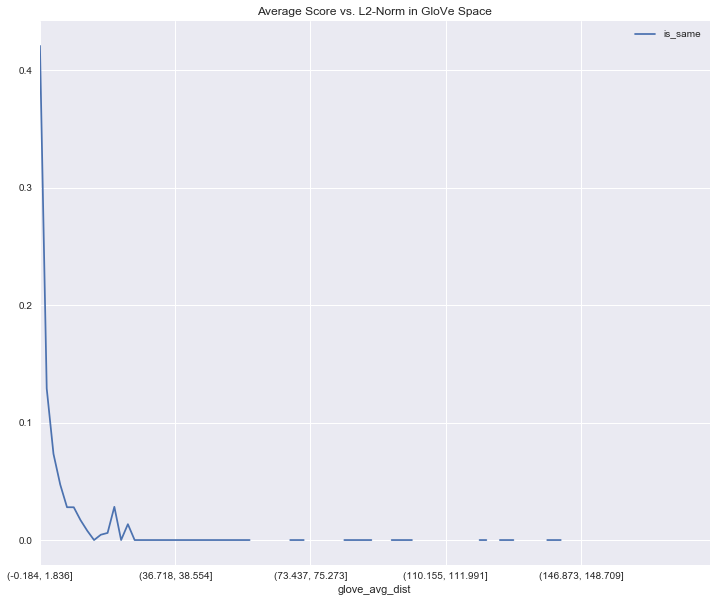

In [151]:
ax = pd.groupby(glove_train_df, pd.cut(glove_train_df['glove_avg_dist'],
                                100))[['is_same']].mean().plot(title='Average Score vs. L2-Norm in GloVe Space')
plt.savefig('../images/l2glove.png')

In [152]:
log_glove = LogisticRegression(class_weight='balanced')
log_glove.fit(glove_train_df['glove_avg_dist'][:, np.newaxis], glove_train_df['is_same'][:, np.newaxis]);

/Users/maded/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [154]:
generate_report(test_data['is_same'], log_glove.predict(glove_avg_dist_test[:, np.newaxis]),
                    log_glove.predict_proba(glove_avg_dist_test[:, np.newaxis])[:, 1])

Loss Report
-----------

Accuracy Score: 0.5982
ROC  AUC Score: 0.6831
Log Loss Score: 0.6355


(0.59823880080144454, 0.68311755489981352, 0.63552639987932369)

## Adding Angle and L1-Distance

In [174]:
def get_angle(q1, q2):
    angle = np.sum(q1 * q2, axis=1)
    return angle

def get_l1_dist(q1, q2):
    dist = np.sum(np.abs(q1 - q2), axis=1)
    return dist

In [175]:
w2v_angle, glove_angle = get_angle(vecs_q1, vecs_q2), get_angle(glove_vecs_q1, glove_vecs_q2)

In [190]:
w2v_angle_test, glove_angle_test = get_angle(vecs_q1_test, vecs_q2_test), get_angle(glove_vecs_q1_test,
                                                                                    glove_vecs_q2_test)

In [176]:
w2v_dist, glove_dist = get_l1_dist(vecs_q1, vecs_q2), get_l1_dist(glove_vecs_q1, glove_vecs_q2)

In [192]:
w2v_dist_test, glove_dist_test = get_l1_dist(vecs_q1_test, vecs_q2_test), get_l1_dist(glove_vecs_q1_test,
                                                                                    glove_vecs_q2_test)

In [200]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

mlp_model = Sequential([
    Dense(32, input_shape=(2,)),
    Activation('relu'),
    Dense(20),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])

mlp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [201]:
mlp_model.fit(np.vstack((w2v_angle, w2v_dist)).T, w2v_df['is_same'][:, np.newaxis], epochs=10, batch_size=64)

Epoch 1/10
323430/323430 [==============================] - 9s 28us/step - loss: 0.5959 - acc: 0.6641
Epoch 2/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5722 - acc: 0.6776
Epoch 3/10
323430/323430 [==============================] - 8s 26us/step - loss: 0.5670 - acc: 0.6802
Epoch 4/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5634 - acc: 0.6825
Epoch 5/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5616 - acc: 0.6848
Epoch 6/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5604 - acc: 0.6850
Epoch 7/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5590 - acc: 0.6870
Epoch 8/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5578 - acc: 0.6883
Epoch 9/10
323430/323430 [==============================] - 8s 25us/step - loss: 0.5572 - acc: 0.6889
Epoch 10/10
323430/323430 [==============================] - 8s 26us/step - loss: 

In [202]:
preds = mlp_model.predict(np.vstack((w2v_angle_test, w2v_dist_test)).T).flatten()
class_preds = (preds > 0.5).astype('int')
generate_report(test_data['is_same'], class_preds,
                preds)

Loss Report
-----------

Accuracy Score: 0.6721
ROC  AUC Score: 0.7331
Log Loss Score: 0.5634


(0.67205085710045265, 0.73312106851972847, 0.56343881863910228)

In [203]:
preds = mlp_model.predict(np.vstack((glove_angle_test, glove_dist_test)).T).flatten()
class_preds = (preds > 0.5).astype('int')
generate_report(test_data['is_same'], class_preds,
                preds)

Loss Report
-----------

Accuracy Score: 0.6335
ROC  AUC Score: 0.7007
Log Loss Score: 0.6902


(0.63345041680065306, 0.7007193604585622, 0.69023440339179054)